In [1]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = (
    tf.OptimizerOptions.ON_1)
config.intra_op_parallelism_threads = 1
config.inter_op_parallelism_threads = 1
sess = tf.InteractiveSession(config=config)

# Linear Regression

In [3]:
# Logp calculation for linear regression 
@pm.model
def linreg(sd_prior='half_normal', n_points = 100):    
    # Define priors
    sigma = pm.HalfNormal('sigma', scale = 10)
    intercept = pm.Normal('Intercept', 0, scale=10)
    x_coeff = pm.Normal('weight', 0, scale = 5)
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm.Normal('y', loc=intercept + x_coeff * x, scale=sigma)
    
    
model = linreg.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'sigma': 2.1540835,
 'Intercept': -9.8933735,
 'weight': -3.5021636,
 'y': array([  6.3240542 ,   4.9349074 ,   8.008871  ,   8.025118  ,
          7.7940035 ,   6.538599  ,   4.095637  ,   2.8069854 ,
          5.6411905 ,   5.3767724 ,   5.8603096 ,   6.3269186 ,
          1.282798  ,   2.346976  ,   5.200045  ,  -0.24768591,
          1.320301  ,   0.17908072,   2.1627207 ,  -4.298492  ,
          3.3085706 ,   0.31804517,   0.06954949,   0.9330467 ,
         -2.7704456 ,  -2.3848624 ,  -1.7321088 ,   1.8835077 ,
         -3.1845412 ,  -4.1842594 ,  -6.15857   ,  -1.2500737 ,
         -1.6041977 ,  -3.5481005 ,  -0.39644146,  -4.9611244 ,
         -4.6241713 ,  -4.8972197 ,  -4.4516897 ,  -8.6029005 ,
         -4.6847224 ,  -6.548435  ,  -7.9896717 ,  -5.5331616 ,
         -9.678636  ,  -8.76811   , -10.322547  ,  -8.529482  ,
        -13.830505  ,  -9.194611  , -11.62426   , -14.712478  ,
        -13.760939  , -12.028528  ,  -8.718004  , -11.343339  ,
        -13.738695  ,  -8.529

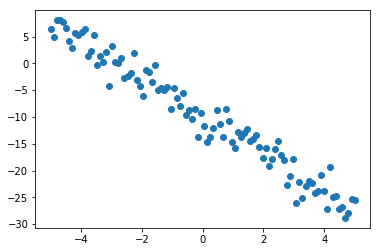

In [4]:
plt.scatter(np.linspace(-5, 5, 100), forward_sample['y'])

In [5]:
func = model.make_log_prob_function()
sigma = tf.placeholder(tf.float32)
intercept = tf.placeholder(tf.float32)
x_coeff = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32, shape=(100,))
logp = func(sigma, intercept, x_coeff, y)


In [6]:
feed_dict = {sigma: forward_sample['sigma'], 
            intercept: forward_sample['Intercept'], 
            x_coeff: forward_sample['weight'], 
            y: forward_sample['y']}

sess.run(logp, feed_dict=feed_dict)

-225.04695

In [7]:
import pymc3 as pm3

/anaconda3/envs/GSoC/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 2388 is still running
  ResourceWarning, source=self)
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/misc/cpucount.py:48: ResourceWarning: unclosed file <_io.TextIOWrapper name=59 encoding='UTF-8'>
  num = int(os.popen('sysctl -n hw.ncpu').read())
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/lazylinker_c.py:129: ResourceWarning: unclosed file <_io.TextIOWrapper name='/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/c_code/lazylinker_c.c' mode='r' encoding='UTF-8'>
  code = open(cfile).read()
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/tests/main.py:6: DeprecationWarning: Import

In [8]:
n_points = 100
with pm3.Model() as model3: 
    # Define priors
    sigma = pm3.HalfNormal('sigma', sd = 10, observed=forward_sample['sigma'])
    intercept = pm3.Normal('Intercept', 0, 10, observed=forward_sample['Intercept'])
    x_coeff = pm3.Normal('weight', 0, 5, observed=forward_sample['weight'])
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm3.Normal('y', intercept + x_coeff * x, sigma, observed=forward_sample['y'])
    
model3.logp()

/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py

array(-225.04694534)

# Centered-Eight 

In [9]:
schools = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = tf.to_float(np.array([15., 10., 16., 11.,  9., 11., 10., 18.]))
n_points = 8

@pm.model
def centered_eight(n_points = n_points):    
    # Define priors
    mu = pm.Normal('mu', loc = 0, scale = 5)
    tau = pm.HalfCauchy('tau', loc = 0, scale = 5)
    theta = pm.Normal('theta', loc = tf.fill([8], mu.as_tensor()), scale = tf.fill([8], tau.as_tensor()))
    # Awkward syntax: Feature?
    
    # Define likelihood
    y = pm.Normal('y', loc = theta, scale = sigma)
    
model = centered_eight.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'mu': -0.10470855,
 'tau': 28.388956,
 'theta': array([ -5.917181,  35.44701 ,  -6.457119, -55.13451 ,  10.85443 ,
        -21.278284, -21.195353,   6.901861], dtype=float32),
 'y': array([ -1.6446066,  27.70166  , -15.382467 , -47.940907 ,  12.278376 ,
        -25.154694 , -40.317635 ,  18.134832 ], dtype=float32)}

In [10]:
func = model.make_log_prob_function()
mu = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
theta = tf.placeholder(tf.float32, shape=(n_points,))
y = tf.placeholder(tf.float32, shape=(n_points,))
logp = func(mu, tau, theta, y)

In [ ]:
feed_dict = {mu: forward_sample['mu'], 
            tau: forward_sample['tau'], 
            theta: forward_sample['theta'], 
            y: schools}

sess.run(logp, feed_dict=feed_dict)

In [ ]:
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
with pm3.Model() as model3: 
    # Define priors
    mu = pm3.Normal('mu', 0, sd = 5, observed=forward_sample['mu'])
    tau = pm3.HalfCauchy('Intercept', 5, observed=forward_sample['tau'])
    theta = pm3.Normal('weight', mu, tau, observed=forward_sample['theta'])
    
    # Define likelihood
    y = pm3.Normal('y', theta, sigma, observed=schools)
    
model3.logp()